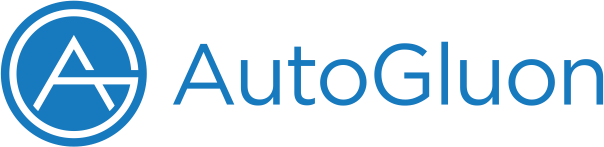

This is the notebook seen at lesson, modified to evaluate my dataset.

# **Entity Embeddings with Autogluon**

AutoGluon  offer high performance and automatic optimization techniques such as model selection, hyper-parameter calibration, and features learning through iterative computations of appropriate loss functions. Aswe have seen for Fastai Autogluon is easy to use: we don't need to do manually all the passages we see in Tensor Flow to prepare the dataset (e.g encoding of categorical variables, categorical embeddings, model definition, specify LR ...). Also we don't need to build manually our model since the framework will set the optimal model in respect of the given dataset !

# **Import & Load**

First, we import the packages we need. Then we upload the datasest as csv and load it on a Pandas Dataframe. This time we use the Python's package manager ***pip*** to retrieve autogluon packages (there may be some warnings in the output: don't worry and go further)

In [6]:
!pip install jedi==0.10
!pip install --upgrade pip
!pip install --upgrade setuptools wheel
!pip install --upgrade "mxnet<2.0.0"
!pip install --pre autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 16.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We import what we need to build and run our model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint
import random
from autogluon.tabular import TabularPredictor
import mxnet as mx

Then, we upload our dataset 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset(2).csv to dataset(2).csv


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['dataset(2)singlelabel.csv']))
# Dataset is now stored in a Pandas Dataframe

KeyError: ignored

Finally we load the uploaded dataset into a Dataframe

# **Prepare the dataset**
Before splitting our dataset into TRAINING, VALIDATION and TEST sets we had to inspect our data in order to make them more suitable for a DNN. Also, we want to drop "cheating" columns (timestamp, ports, ...), as you have learnt in previous parts of the courses. Let's have a look!  

In [ ]:
data

We drop the meaningless columns and the time column.

In [ ]:
# Drop the unnecessary columns
data = data.drop('time', axis=1)
data = data.drop('total_tasks', axis=1)
data = data.drop('running_tasks', axis=1)
data = data.drop('sleeping_tasks', axis=1)
data = data.drop('cpu_nice', axis=1)
data = data.drop('cpu_idle', axis=1)
data = data.drop('cpu_wait', axis=1)
data = data.drop('memory_total', axis=1)
data = data.drop('vm_total', axis=1)
data = data.drop('vm_free', axis=1)
data = data.drop('vm_used', axis=1)

Dataset already shuffled


Also we use the following code to see if there are unuseful feature in the dataset

In [ ]:
data.nunique()

Dataset splitted 50:50 to match the training of other models

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.50)

Then we encode the multilabel column as integers in order to have only 0 for "normal" behaviour and 1 for the attacks.
Then we create y_train and y_test vectors extracting the binlabel column from train and test sets, respectively. **Since we don't want to cheat, we drop the multilabel column from the test set.**

In [ ]:
#Converting string values of binlabel feature into integers

test.loc[test['multilabel']!="normal", 'multilabel']=0
test.loc[test['multilabel']=="normal", 'multilabel']=1
train.loc[train['multilabel']!="normal", 'multilabel']=0
train.loc[train['multilabel']=="normal", 'multilabel']=1

y_train = train['multilabel']
y_test = test['multilabel']

test = test.drop('multilabel', axis=1)


In [ ]:
y_train

In [ ]:
y_test

In [ ]:
train

In [ ]:
test

# **Building the Model**
Autogluon make this step easy: we only have to import the TabularPredictor module, instantiate a tabular predictor and specify our label

In [ ]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(label='multilabel')

# **Training the model**

The only thing to do here is to call the fit module passing our TRAIN set as input. 

In [ ]:
predictor.fit(train, hyperparameters='multimodal', excluded_model_types= ['KNN','RF','XT','GBM', 'GBMXT', "CB", "XGB"])

Autogluon train a set of classifiers: we are interessed in the NeuralNetMXNet

In [ ]:
predictor.fit_summary()

# **Using the trained model for classification**


We select one of the models to do our prediction over the test set

In [ ]:
#selection of neural network

models = predictor.get_model_names()
nn_name = models[1]
print(nn_name)

In [ ]:
# Prediction using NeuralNetMXNet only
y_pred = [x for x in predictor.predict(test, model=nn_name)]

y_test is not in the same format as y_pred. We use the to_numpy function to obtain a plain array.

In [ ]:
y_test = [x for x in y_test]

# **Evaluating the Model**

Finally we can evaluate the model, comparing y_test and y_pred

In [ ]:
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

print(cm)

TN = cm[0,0]
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [ ]:
print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)